In [175]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import json
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

## Datos Completos de los Clientes

### Visualización de todos los datos

In [176]:
clients_data = pd.read_csv('datos_de_clientes.csv', delimiter='\t')

#show all the data withouth truncating

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Transformaciones

### Análisis y limpieza del estado civil

In [177]:
# show the categories of the columns

keys = ['Marital_Status']
Marital_categories = clients_data['Marital_Status'].unique()

# create a dictionary for each categories
marital_status_categories_dict = dict(zip(Marital_categories, range(len(Marital_categories))))

# asining a number to each category in a new column
clients_data['Marital_Status'] = clients_data['Marital_Status'].map(marital_status_categories_dict)

# eliminate the register of marital status 6 and 7 
clients_data = clients_data[clients_data['Marital_Status'] < 6]

#change all the marital status with value 0,3,4,5 to 0
clients_data['Marital_Status'] = clients_data['Marital_Status'].replace(5, 0)
clients_data['Marital_Status'] = clients_data['Marital_Status'].replace(4, 0)
clients_data['Marital_Status'] = clients_data['Marital_Status'].replace(3, 0)

#change all the marital status with value 1,2 to 1
clients_data['Marital_Status'] = clients_data['Marital_Status'].replace(2, 1)

#print(clients_data['Marital_Status'].unique())

clients_data.drop(columns=['ID','Z_CostContact','Z_Revenue'], inplace=True)


Podemos ver que en nuestros datos contamos con 7 posibles estados civiles inicialmente podemos ver que 2 de estos 7 estados son completamente inutiles, estos esatos don Yolo y Absurd, estoas datos no son datos serios por lo que no se necesitan. 

Asurd, YOLO -> categorias eliminadas (registros que las incluyan de igualmanera son eliminados)

Con las 5 categorias restantes otra de las transformaciones que se va a realizar para asi minimizar las categorias a analizar para esto, es agrupar aquellos estados que representan una parja estable o una persona que se encuentra soltera

Dentro del grupo de parejas se encuentran aquellos que estn en la categoria Together y Married, mientras que los que son catalogados son aquellos que pertenecen a las categorias de Singel, Divorced, Widow y Alone, asi reducimos de los 6 posibles estados civiles a unicamente dos, el reemplazo se haria de la siguiente manera 

{Single, Divoreced, Widow, Alone} ----> personas solteras (id:0)  
{Together, Married} ----> personas con pareja (id:1)

Para este proceso lo primero es asignarle un id individual a cada uno de los estados y luego reemplazrlos segun la catergoria a la que pertenezcan 

### Generar las edades de los clientes

In [178]:
def edades(fecha_nacimiento):
    edad = 2024 - fecha_nacimiento
    return edad
clients_data['Age'] = clients_data['Year_Birth'].apply(edades)
age = clients_data.pop('Age')
clients_data.insert(2, 'Age', age)


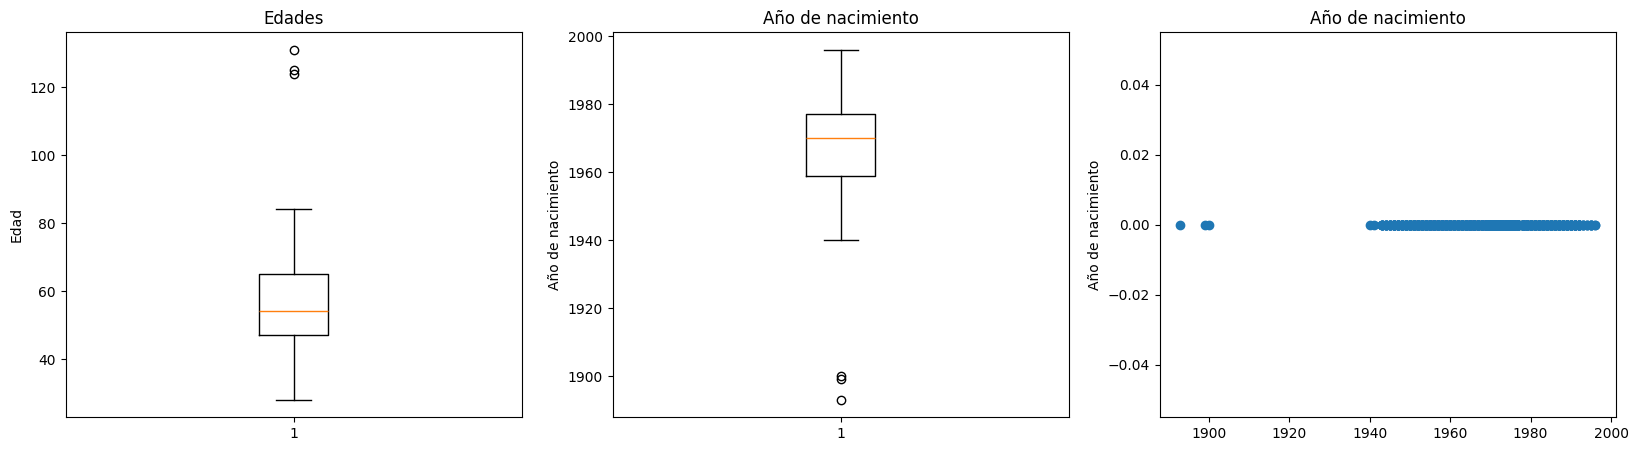

In [179]:
# ages and birth date boxplot

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].boxplot(clients_data['Age'])
ax[0].set_title('Edades')
ax[0].set_ylabel('Edad')
ax[1].boxplot(clients_data['Year_Birth'])
ax[1].set_title('Año de nacimiento')
ax[1].set_ylabel('Año de nacimiento')
ax[2].scatter(clients_data['Year_Birth'], np.zeros(len(clients_data['Year_Birth'])))
ax[2].set_title('Año de nacimiento')
ax[2].set_ylabel('Año de nacimiento')
plt.show()


Des pues de obtener las edades de todos los clientes presentes en el data set, nos dimos cuenta que habian algunos clientes que tenian edades aproximadas o superiores a los 120 años, valores que no tienen sentido y la verdad no son para nada utiles en el analisis a realizar en el reto, por lo que decidimos verificar cuales eran los años de nacimiento de dichas personas, además de observar la dispersión que generaban estos datos. 

Se puede ver que estas edades que generan ruido y dispersan las graficas, son inferiores al año 1930 por lo que si estos registros son eliminados para eliminar dicha dispersión y estandarizar el rango de las edades a uno mucho más util 

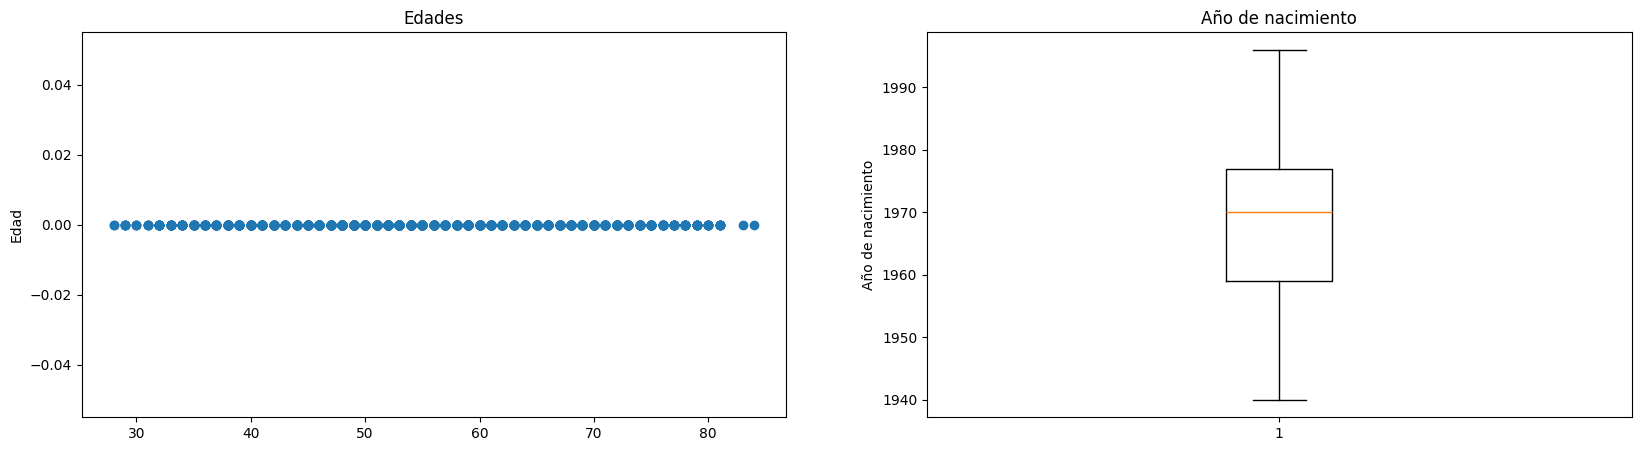

In [180]:
# drop the registers with a year of birth lower than 1930
clients_data = clients_data[clients_data['Year_Birth'] > 1930]

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].scatter(clients_data['Age'], np.zeros(len(clients_data['Age'])))
ax[0].set_title('Edades')
ax[0].set_ylabel('Edad')
ax[1].boxplot(clients_data['Year_Birth'])
ax[1].set_title('Año de nacimiento')
ax[1].set_ylabel('Año de nacimiento')
plt.show()

Con estas nuevas graficas podemos ver que ya no tenemos datos outliers que genere ruido en los datos a analizar, ademas podemos ver que el rango de edades estan entre un poco menos de los 30 años y un poco más de los 80 años, valores que nos permiten analizar mucho mejor el grupo demografico al cual se le enfocara la campaña segun su edad

### Cambiar los valores de categoricos de Educación por id

In [181]:
# show the categories of the columns

Education_categories = clients_data['Education'].unique()

# create a dictionary for each categories
Education_categories_order=[Education_categories[3],Education_categories[0],Education_categories[4],Education_categories[2],Education_categories[1]]
Education_categories_dict = dict(zip(Education_categories_order, range(len(Education_categories_order))))
print(Education_categories_dict)

clients_data['Education'] = clients_data['Education'].map(Education_categories_dict)

{'Basic': 0, 'Graduation': 1, '2n Cycle': 2, 'Master': 3, 'PhD': 4}


### Obtener el tiempo inscritos en la compañia

### Obtener el tiempo inscritos en la compañia

In [182]:
def contar_dias(desde_fecha):
    fecha_actual = datetime.now().date()
    fecha_desde = datetime.strptime(desde_fecha, '%d-%m-%Y').date()
    diferencia = fecha_actual - fecha_desde
    return diferencia.days

clients_data['Tiempo_afiliado'] = clients_data['Dt_Customer'].apply(contar_dias)
tmp = clients_data.pop('Tiempo_afiliado')
clients_data.insert(8, 'Tiempo_afiliado', tmp)
clients_data.drop(columns=['Dt_Customer'], inplace=True)

clients_data.drop(columns=['Year_Birth'], inplace=True)

### Calcula la cantidad de participaciones en campañas

In [183]:
accepted_campaigns= clients_data['AcceptedCmp1']+clients_data['AcceptedCmp2']+clients_data['AcceptedCmp3']+clients_data['AcceptedCmp4']+clients_data['AcceptedCmp5']+clients_data['Response']
clients_data.insert(20, 'Campañas Aceptadas', accepted_campaigns)
clients_data.drop(columns=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response'], inplace=True)

### Hacer imputation del income

In [195]:
not_nan_income = clients_data['Income'].dropna()
prom_income = np.mean(not_nan_income)
clients_data['Income'] = clients_data['Income'].fillna(prom_income)


### Hace la normalizacion de todas las columnas que lo necesitan en la tabla

In [185]:

def normalize_data(data, columns):
    scaler = MinMaxScaler()
    data[columns] = scaler.fit_transform(data[columns])
    return data

columns = ['Education','Age','Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Campañas Aceptadas']
clients_data_normalized = clients_data.copy() 
clients_data_normalized = normalize_data(clients_data_normalized, columns)


,Education,Age,Marital_Status,Income,Kidhome,Teenhome,Tiempo_afiliado,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Campañas Aceptadas,Complain
0,0.25,0.696429,0,0.084832,0.0,0.0,4234,0.585859,0.425318,0.442211,0.316522,0.664093,0.334601,0.243094,0.200000,0.296296,0.357143,0.307692,0.35,0.2,0
1,0.25,0.750000,0,0.067095,0.5,0.5,3684,0.383838,0.007368,0.005025,0.003478,0.007722,0.003802,0.016575,0.133333,0.037037,0.035714,0.153846,0.25,0.0,0
2,0.25,0.553571,1,0.105097,0.0,0.0,3883,0.262626,0.285332,0.246231,0.073623,0.428571,0.079848,0.116022,0.066667,0.296296,0.071429,0.769231,0.20,0.0,0
3,0.25,0.214286,1,0.037471,0.5,0.0,3710,0.262626,0.007368,0.020101,0.011594,0.038610,0.011407,0.013812,0.133333,0.074074,0.000000,0.307692,0.30,0.0,0
4,1.00,0.267857,1,0.085065,0.5,0.0,3732,0.949495,0.115874,0.216080,0.068406,0.177606,0.102662,0.041436,0.333333,0.185185,0.107143,0.461538,0.25,0.0,0
5,0.75,0.517857,1,0.091412,0.0,0.5,3864,0.161616,0.348292,0.211055,0.056812,0.000000,0.159696,0.038674,0.133333,0.222222,0.142857,0.769231,0.30,0.0,0
6,0.25,0.446429,0,0.081068,0.0,0.5,4164,0.343434,0.157401,0.326633,0.095072,0.193050,0.186312,0.074586,0.266667,0.259259,0.107143,0.538462,0.30,0.0,0
7,1.00,0.196429,1,0.047710,0.5,0.0,3988,0.323232,0.050904,0.050251,0.032464,0.011583,0.003802,0.063536,0.133333,0.148148,0.000000,0.307692,0.40,0.0,0
8,1.00,0.392857,1,0.043043,0.5,0.0,3959,0.191919,0.009377,0.000000,0.013913,0.011583,0.011407,0.005525,0.066667,0.111111,0.000000,0.153846,0.45,0.2,0
9,1.00,0.821429,1,0.005892,0.5,0.5,3679,0.686869,0.018754,0.000000,0.003478,0.003861,0.003802,0.035912,0.066667,0.037037,0.000000,0.000000,1.00,0.2,0
